# Autoencoder and Variational Autoencoder（圖像化顯示）


## 1. 初始準備

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


## 2. 讀入 MNIST 數據庫

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


In [5]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

# 3. Autoencoder

In [6]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

h = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(h))

autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [7]:
#autoencoder.compile(loss='mse', optimizer=Adam())
#autoencoder.fit(x_train, x_train, batch_size=1024, epochs=100)

* 使用預先設定好的權重

In [8]:
autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

### Encoder 視覺化

In [9]:
Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [10]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, dec_1(dec_2(h_input)))
Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


第 14076 圖的 latent 表示為 [[6.9198257e-04 8.0504376e-01]]


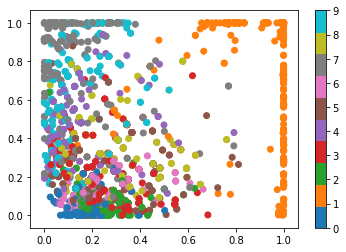

In [11]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

indices = np.random.randint(x_test.shape[0], size=3000)

latents = Encoder.predict(x_test[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap="tab10")
plt.colorbar()
plt.show()

### Decoder視覺化

# 4.Variational Autoencoder

In [12]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [13]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [14]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [15]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

dec_x = dec_2(z)
x_hat = dec_1(dec_x)

VAE = Model(x, x_hat)
VAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 784)           0                                            
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 100)           78500       input_3[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 2)             202         dense_5[0][0]                    
____________________________________________________________________________________________________
dense_7 (Dense)                  (None, 2)             202         dense_5[0][0]                    
___________________________________________________________________________________________

* 定義loss function

In [16]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [17]:
#可以自己train
#VAE.compile(loss=vae_loss, optimizer=Adam())
#VAE.fit(x_train, x_train, batch_size=32, epochs=100)

In [18]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

In [19]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [20]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [21]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 31850 圖的 latent 表示為 [[-0.8159291   0.11479515]]


In [22]:
VAE_latents = VAE_Encoder.predict(x_test[indices])

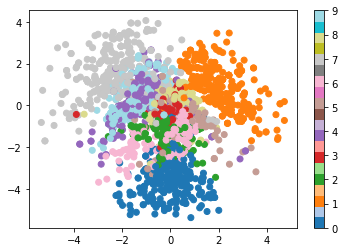

In [23]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [24]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [25]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

NameError: name 'n' is not defined

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

# 作業互動部份： 可以手動輸入想要觀察的數字index,之後再以圖像化顯示

### Input two "number index" that you might like to compare(from0~59999)


* 手動輸入想要觀察的數字index

In [27]:
first_num = input('>> ')
print("The first number is %s"%y_train0[int(first_num)])
second_num = input('>> ')
print("The Second number is %s"%y_train0[int(second_num)])

>> 5000
The first number is 7
>> 60
The Second number is 4


In [28]:
data_0 = x_train0[int(first_num)]
data_1 = x_train0[int(second_num)]


In [29]:
def inBetween(t):
    data_0 = x_train0[int(first_num)]
    data_1 = x_train0[int(second_num)]
    data_t = (1-t)*x_train0[int(first_num)] + t*x_train0[int(second_num)]

    mu_0 = VAE_Encoder.predict(x_train[int(first_num):int(first_num)+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[int(second_num):int(second_num)+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 1)
    
    ax1.scatter(mu_0[0], mu_0[1],c = 'Red')
    ax1.scatter(mu_1[0], mu_1[1],c = 'Blue')
    ax1.scatter(mu_t[0], mu_t[1],c = 'Purple')
    plt.plot([mu_0[0],mu_1[0]],[mu_0[1],mu_1[1]],'--g')
    
    ax2 = plt.subplot(2, 3, 4)
    ax2.imshow(data_0, cmap='Reds')


    ax3 = plt.subplot(2, 3, 5)
    ax3.imshow(data_t, cmap='Purples')

    
    ax4 = plt.subplot(2, 3, 6)
    ax4.imshow(data_1, cmap='Blues')

* 圖像化顯示

In [30]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.1,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.inBetween(t)>